## CIFAR-10 Classifier Using CNN in PyTorch




### CIFAR-10 Dataset:

The CIFAR-10 data set has 60,000 32x32 colour images, 6,000 images per class. It has the 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src = "https://pytorch.org/tutorials/_images/cifar10.png"/>


#### Load important libraries 

In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD,lr_scheduler
from torch.autograd import Variable
import pickle
import seaborn as sns
import numpy as np


In [41]:
# Initialize GPU 'cuda' device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


#### Load and Normalize the CIFAR 10 data

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [43]:
# Check the shape of data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


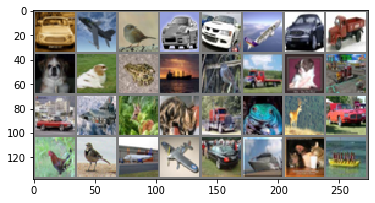

  car plane  bird   car   car plane   car truck   dog   dog  frog  ship  bird truck   dog truck   car plane  deer   cat truck  frog  deer   car  bird  bird plane plane   car  ship   cat  ship


In [44]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

### 2. Define a Convolutional Neural Network


In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
        
        resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        in_features = resnet.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
          x = self.resnet(x)
          x = self.drop(x.view(-1,self.final.in_features))
          return self.final(x)

net = Net()

In [46]:
# Transfer neural network to the GPU
net.to(device)

Net(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

### 3. Define a Loss function and optimizer

Use a Classification Cross-Entropy loss and SGD with momentum.


In [0]:
import torch.optim as optim

param_groups = [
    {'params':net.resnet.parameters(),'lr':.0001},
    {'params':net.final.parameters(),'lr':.001}
    
]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


### 4. Train the network

In [48]:
num_epochs = 10
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    running_acc = 0
    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
        out = torch.argmax(output.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    
    train_tracker.append(cum_loss/len(trainloader))
    #print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)}")
    print(f"Train loss {epoch+1}: {cum_loss/len(trainset)}| Train Acc:{running_acc*100/len(trainset)}%")



Train loss 10: 0.036029209414720535| Train Acc:60.962%
Train loss 10: 0.02257170606017113| Train Acc:75.614%
Train loss 10: 0.01784282651692629| Train Acc:80.95%
Train loss 10: 0.014505285506099462| Train Acc:84.694%
Train loss 10: 0.011769848159104585| Train Acc:87.426%
Train loss 10: 0.009535188364684581| Train Acc:89.758%
Train loss 10: 0.007836438770145178| Train Acc:91.592%
Train loss 10: 0.006595574920028448| Train Acc:92.856%
Train loss 10: 0.005407194464281202| Train Acc:94.37%
Train loss 10: 0.005372735963501036| Train Acc:94.542%


### 5. Test the network on the test data

In [49]:
with torch.no_grad():
  for epoch in range(num_epochs):

      test_loss, num_correct,  total = 0, 0, 0
      predictions = []
      zero_matrix = np.zeros([10,10], int)
      
      for batch, (images, labels) in enumerate(testloader,1):
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = net(images)
          batch_loss = criterion(outputs, labels)        
          test_loss += batch_loss.item()
          _, predicted = torch.max(outputs.data, 1)
          predictions.append(outputs)
          output = torch.exp(outputs)
          pred = torch.argmax(output, 1)
          total += labels.size(0)
          num_correct += (pred == labels).sum().item()
          for i, l in enumerate(labels):
              zero_matrix[l.item(), predicted[i].item()] += 1
      test_tracker.append(test_loss/len(testloader))
      print(f"Test loss: {test_loss/len(testloader)} | ", end='')
      accuracy_tracker.append(num_correct/total)
      print(f'Accuracy : {num_correct/total}')        
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after 10 epochs on the 10000 test images: {num_correct * 100 / total}% ')


Test loss: 0.7778311401319961 | Accuracy : 0.812
Test loss: 0.7716410561158253 | Accuracy : 0.8123
Test loss: 0.7798755436707229 | Accuracy : 0.8125
Test loss: 0.7753025205038226 | Accuracy : 0.8119
Test loss: 0.7722499253460393 | Accuracy : 0.8119
Test loss: 0.7820631098299743 | Accuracy : 0.8118
Test loss: 0.7734560365922535 | Accuracy : 0.8143
Test loss: 0.7740409579901649 | Accuracy : 0.8138
Test loss: 0.767902602069675 | Accuracy : 0.8131
Test loss: 0.7729988740608335 | Accuracy : 0.8119

Number correct : 8119, Total : 10000
Accuracy of the model after 10 epochs on the 10000 test images: 81.19% 


This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

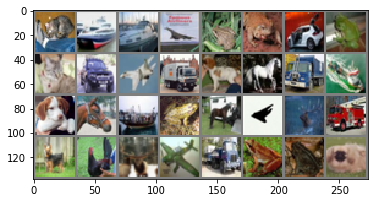

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


In [58]:
dataiter = iter(testloader)
images, labels = dataiter.next()
net.to('cpu')
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

Okay, now let us see what the neural network thinks these examples above are:



In [51]:
 outputs = net(images)
 outputs.argmax()

tensor(137)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [52]:
predicted, index = torch.max(outputs, 1)
for p, i in zip(predicted, index):
    print('{0} - {1:.2f}'.format(classes[i], p))

cat - 9.09
ship - 15.20
ship - 4.32
plane - 6.78
frog - 6.42
frog - 5.77
car - 6.82
frog - 4.26
dog - 4.08
car - 4.09
plane - 5.04
truck - 25.73
cat - 6.60
horse - 41.66
truck - 9.30
ship - 5.99
cat - 6.11
horse - 11.56
ship - 9.90
frog - 8.05
horse - 6.22
bird - 6.13
deer - 8.98
truck - 34.20
deer - 5.71
bird - 4.74
deer - 6.41
bird - 3.99
truck - 9.87
frog - 14.88
frog - 5.97
dog - 5.70


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

What are the classes that performed well, and the classes that did not perform well:

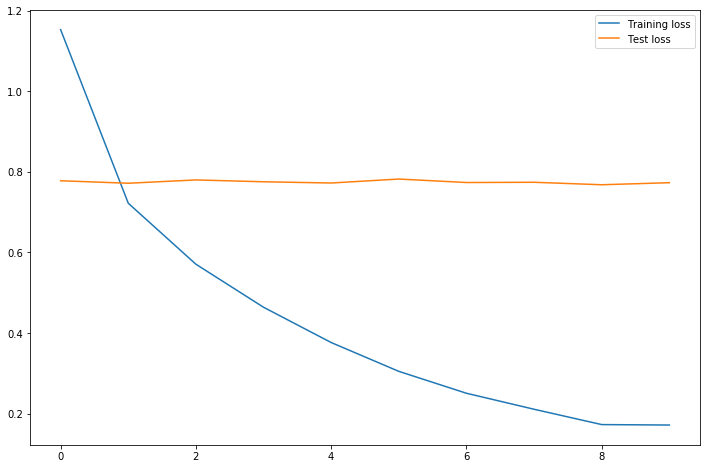

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.legend()

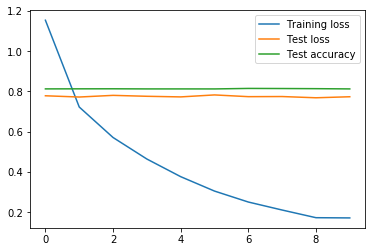

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

In [56]:
print('{0:24s}  {1}'.format('Category','Accuracy'))
for index, raw in enumerate(zero_matrix):
    print('Accuracy of {0:12s}  {1:.2f}%'.format(classes[index], raw[index]/np.sum(raw)*100))

Category                  Accuracy
Accuracy of plane         78.75%
Accuracy of car           86.31%
Accuracy of bird          80.25%
Accuracy of cat           65.29%
Accuracy of deer          88.55%
Accuracy of dog           74.83%
Accuracy of frog          77.90%
Accuracy of horse         83.54%
Accuracy of ship          87.08%
Accuracy of truck         89.88%


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

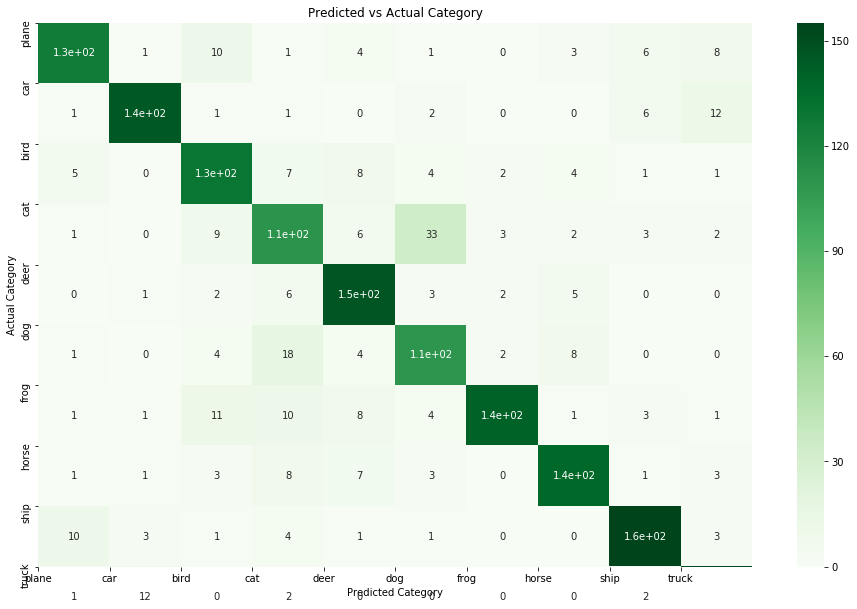

In [57]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.heatmap(zero_matrix, annot=True,cmap="Greens")
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.title('Predicted vs Actual Category')
plt.show()

The visualisation of Predicted Vs Actual category we can see that the best accuracy was achieved on the car and ship categories, darkest shades present on the main diagonal. The truck category was most frequently confused with the car category. This is understandable, since they are both vehicles and have some visual similarities. Planes were also commonly confused with bird and ship. This could have something to do with a common background texture and colour, blue for both sky and sea.

